In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.toy_data import *

import sklearn
import pandas as pd

from operator import xor

# Vanilla Case

In [2]:
m = 1000  # number of models
d = 2  # number of dimensions
noise_type = "class_independent"

# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 0,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 5,
    (0, 1): 5,
    (1, 0): 5,
    (1, 1): 5
}


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))


In [6]:
noise_levels = np.linspace(0, 0.49, num=10)

for loss_type in ["0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy(noise_levels,m,d, X, y, true_labels, instances_counts, loss_type = loss_type)
    plot_metrics_toy(disagreement_rates, noise_levels, title=loss_type)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Misspecify Noise

In [4]:
noise_level = 0.45

noise_levels = np.linspace(-noise_level, 0.49-noise_level, num=20)

for loss_type in ["Corrected 0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy_est_noise(noise_level,m,d, X, y, true_labels, instances_counts, loss_type = loss_type)
    plot_metrics_toy(ambiguity_rates, noise_levels, title=loss_type)

NameError: name 'noise_type' is not defined

# Class Dependent

In [ ]:
m = 10  # number of models
d = 2  # number of dimensions

noise_type = "class_conditional"
fixed_class = 1
fixed_noise = 0.2

# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 25,
    (0, 1): 25,
    (1, 0): 25,
    (1, 1): 25
}


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))


noise_levels = np.linspace(0, 0.49, num=20)

for loss_type in ["0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy(noise_levels,m,d, X, y, true_labels, instances_counts, loss_type = loss_type, noise_type = noise_type, fixed_class = fixed_class, fixed_noise = fixed_noise)
    plot_metrics_toy(ambiguity_rates, noise_levels, title=loss_type)

In [ ]:
noise_levels = np.linspace(0, 0.49, num=20)
losses_dict, accuracy_dict = generate_losses_accuracies(noise_levels,m,d, X, y, true_labels, instances_counts, loss_types = ["0-1 Clean", "0-1 Noisy", "Corrected 0-1 Noisy"])

plot_losses(losses_dict, noise_levels, title=loss_type)
plt.figure()
plot_losses(accuracy_dict, noise_levels)

# Model Misspec

In [7]:

# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): int(xor(bool(0), bool(0))),
    (0, 1): int(xor(bool(0), bool(1))),
    (1, 0): int(xor(bool(1), bool(0))),
    (1, 1): int(xor(bool(1), bool(1)))
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 25,
    (0, 1): 25,
    (1, 0): 25,
    (1, 1): 25
}

m = 100  # number of models
d = 2  # number of dimensions


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

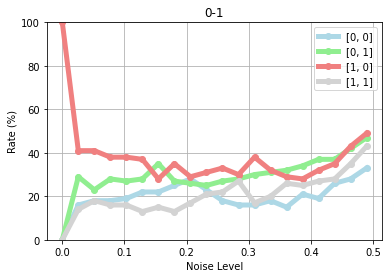

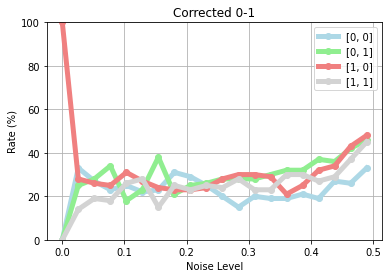

In [8]:
noise_levels = np.linspace(0, 0.49, num=20)

for loss_type in ["0-1", "Corrected 0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy(noise_levels,m,d, X, y, true_labels, instances_counts, loss_type = loss_type)
    plt.figure()
    plot_metrics_toy(ambiguity_rates, noise_levels, title = loss_type)

In [9]:
noise_levels = np.linspace(0, 0.49, num=20)
losses_dict, accuracy_dict = generate_losses_accuracies(noise_levels,m,d, X, y, true_labels, instances_counts, loss_types = ["0-1 Clean", "0-1 Noisy", "Corrected 0-1 Noisy"])

plot_losses(losses_dict, noise_levels, title=loss_type)
plt.figure()
plot_losses(accuracy_dict, noise_levels)

NameError: name 'np' is not defined

# Probabilistic Outcome

In [ ]:
# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 0,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 25,
    (0, 1): 25,
    (1, 0): 25,
    (1, 1): 25
}


# Define the probabilities (p(y=1)) for each feature pair
prob_labels = {
    (0, 0): 0.4,
    (0, 1): 0.4,
    (1, 0): 0.6,
    (1, 1): 0.6
}

# Example usage:
# Coefficients for the logistic model (bias, w1, w2)
weights = calculate_weights(prob_labels)  # Replace with actual weights
# Generate dataset with probabilistic outcomes
X, y = generate_dataset(true_labels, instances_counts, probabilistic = True, weights=weights, seed=2023)

np.unique(y, return_counts=True)

In [ ]:
noise_levels = np.linspace(0, 0.49, num=20)


m = 100  # number of models
d = 2  # number of dimensions


#for loss_type in ["0-1", "Corrected 0-1"]:
for loss_type in ["0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy(noise_levels,m,d, X, y, true_labels, instances_counts, loss_type = loss_type)
    plt.figure()
    plot_metrics_toy(ambiguity_rates, noise_levels, title = loss_type)

In [ ]:
noise_levels = np.linspace(0, 0.49, num=20)
losses_dict, accuracy_dict = generate_losses_accuracies(noise_levels,m,d, X, y, true_labels, instances_counts, loss_types = ["0-1 Clean", "0-1 Noisy", "Corrected 0-1 Noisy"])

plot_losses(losses_dict, noise_levels, title=loss_type)
plt.figure()
plot_losses(accuracy_dict, noise_levels)

# Instance Dependent Noise

In [2]:
m = 100  # number of models
d = 2  # number of dimensions
noise_type = "instance_dependent"

# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 25,
    (0, 1): 25,
    (1, 0): 25,
    (1, 1): 25
}


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))


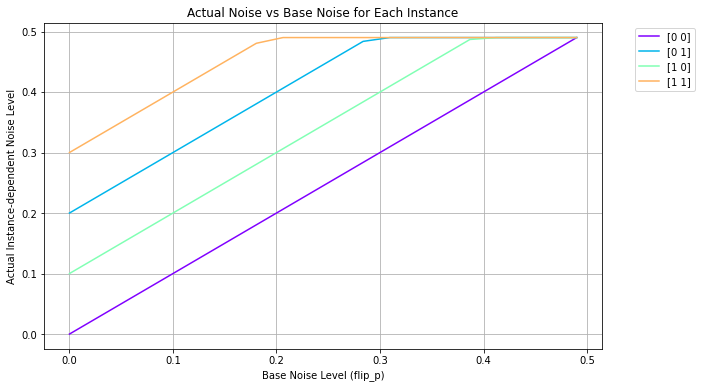

In [25]:
feature_weights = [0.1, 0.2]
noise_levels = np.linspace(0, 0.49, num=20)


# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store colors for each instance to keep consistency across different base noise levels
colors = {}

# Iterate over the unique instances and plot a line for each
for idx, instance in enumerate(np.unique(X, axis=0)):
    # Assign a color for each instance
    color = plt.cm.rainbow(idx / len(np.unique(X, axis=0)))
    colors[str(instance)] = color

    # Calculate actual noise levels across all base noise levels for this instance
    actual_noise_levels = [instance_noise_level(instance, flip_p, feature_weights) for flip_p in noise_levels]
    
    # Plot the line representing actual noise levels for this instance
    ax.plot(noise_levels, actual_noise_levels, label=str(instance), color=color)

# Labeling the plot
ax.set_title('Actual Noise vs Base Noise for Each Instance')
ax.set_xlabel('Base Noise Level (flip_p)')
ax.set_ylabel('Actual Instance-dependent Noise Level')
ax.grid(True)

# Optional: Display legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

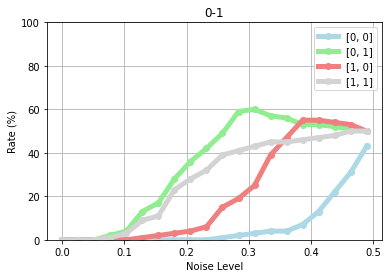

In [16]:


m = 100  # number of models
d = 2  # number of dimensions




#for loss_type in ["0-1", "Corrected 0-1"]:
for loss_type in ["0-1"]:
    ambiguity_rates, disagreement_rates = generate_metrics_toy(noise_levels,m,d, X, y, true_labels, instances_counts, noise_type=noise_type, loss_type = loss_type, feature_weights=feature_weights)
    plt.figure()
    plot_metrics_toy(ambiguity_rates, noise_levels, title = loss_type)

  0%|          | 0/20 [00:00<?, ?it/s]

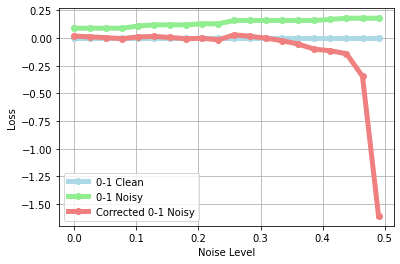

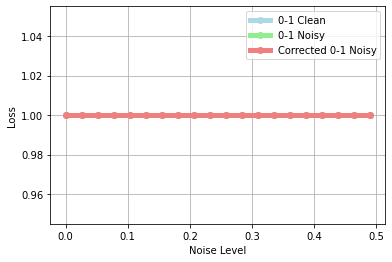

In [5]:
noise_levels = np.linspace(0, 0.49, num=20)
losses_dict, accuracy_dict = generate_losses_accuracies(noise_levels,m,d, X, y, true_labels, instances_counts, noise_type= noise_type, loss_types = ["0-1 Clean", "0-1 Noisy", "Corrected 0-1 Noisy"])

plot_losses(losses_dict, noise_levels)
plt.figure()
plot_losses(accuracy_dict, noise_levels)

In [6]:
for instance in np.unique(X, axis=0):
    
    print(instance_noise_level(instance, 0.4, [-0.1,0.1]))

0.4
0.49
0.30000000000000004
0.4
